In [1]:
import numpy as np 
from recoMRD import recoMRD
import matplotlib.pyplot as plt
from bart import bart

In [2]:
filename = './../example_data/meas_MID00040_FID03385_localizer3D_iPAT2x2integrated.mrd'
mrd = recoMRD(filename)

mrd.img = mrd.kspace_to_image(mrd.kspace['image_scan'])
img_sos = mrd.remove_oversampling(mrd.img)
img_sos = mrd.coil_combination(img_sos, method='sos')
print(mrd.img.shape)
print(img_sos.shape)

MRD file has more than one group. The last group will be imported.
Number of reference scans: 576
Number of image scans: 1330
Acceleration factor: 2 x 2
Reference scan type: integrated
Existing scans: acs, noise, image_scan.
Fully sampled size=[20, 384, 191, 28, 1, 1, 1, 1, 1, 1, 1]


Filling acs       , size=[20, 384, 24, 24, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 576/576 [00:00<00:00, 6204.66it/s]
Filling noise     , size=[20, 384, 1, 1, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 1/1 [00:00<00:00, 2605.16it/s]
Filling image_scan, size=[20, 384, 95, 14, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 1330/1330 [00:00<00:00, 3874.41it/s]
Fourier transform: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Remove oversampling... Done.
(20, 384, 191, 28, 1, 1, 1, 1, 1, 1, 1)
(1, 192, 191, 28, 1, 1, 1, 1, 1, 1, 1)


(192, 191, 28)
(192, 191, 10)


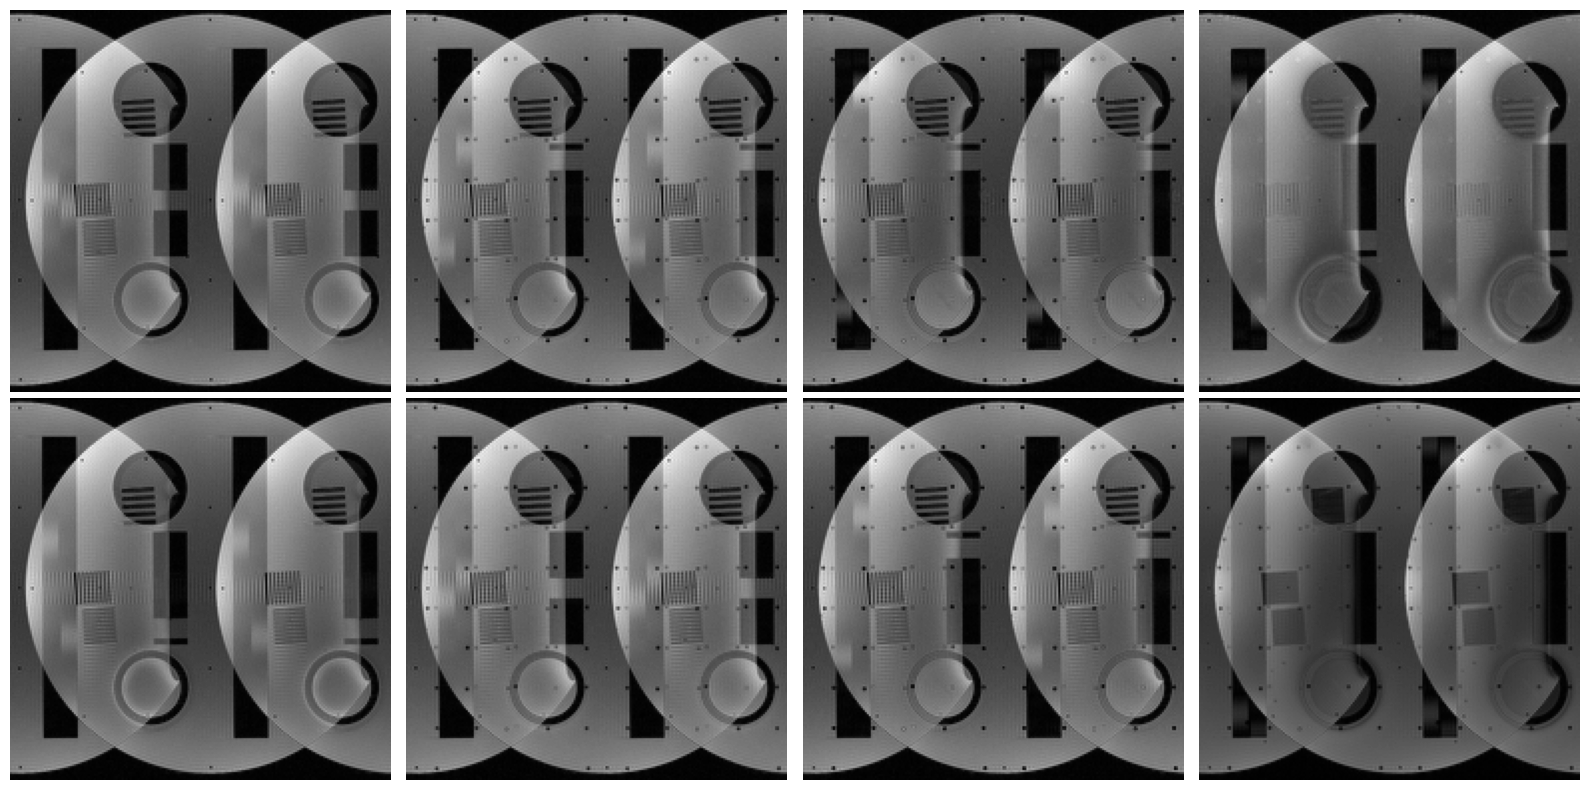

In [3]:
# sum of square reco
print(img_sos.squeeze().shape)
temp = img_sos.squeeze()[...,::3]
print(temp.shape)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[...,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout()  

(384, 191, 28)


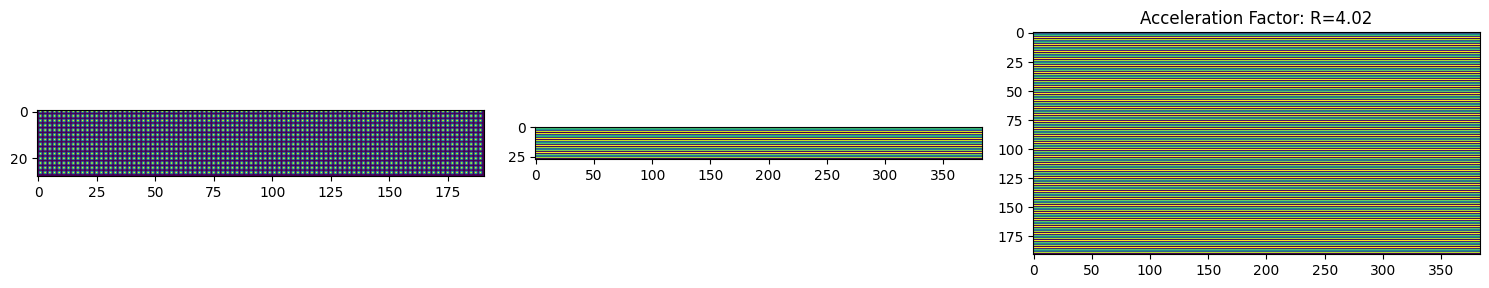

In [4]:
# show sampling pattern
temp = mrd.kspace['image_scan'].squeeze()[0,...]
mask = bart.bart(1, 'pattern', temp).real
print(mask.shape)
shp = [x // 2 for x in mask.shape]
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor
fig, axes = plt.subplots(1,3, figsize=(15, 5))
axes[0].imshow(np.abs(mask[shp[0],:,:]).T)
axes[1].imshow(np.abs(mask[:,shp[1],:]).T)
axes[2].imshow(np.abs(mask[:,:,shp[2]]).T)
plt.title('Acceleration Factor: R={:.2f}'.format(R))
plt.tight_layout()

(20, 384, 24, 24, 1, 1, 1, 1, 1, 1, 1)
(5, 384, 24, 24)


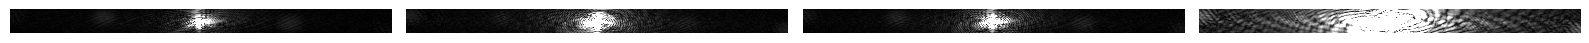

In [5]:
# show some Rx channels from reference scan
print(mrd.kspace['acs'].shape)
temp = mrd.kspace['acs'].squeeze()[::4,...]
print(temp.shape)
fig, axes = plt.subplots(1,4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(np.abs(temp[i,...,temp.shape[3]//2]).T,cmap='gray', vmax=1e-4)
    axes[i].set_axis_off()
plt.tight_layout() 

Fourier transform: 100%|██████████| 20/20 [00:00<00:00, 106.85it/s]


Remove oversampling... Done.
(192, 24, 8)


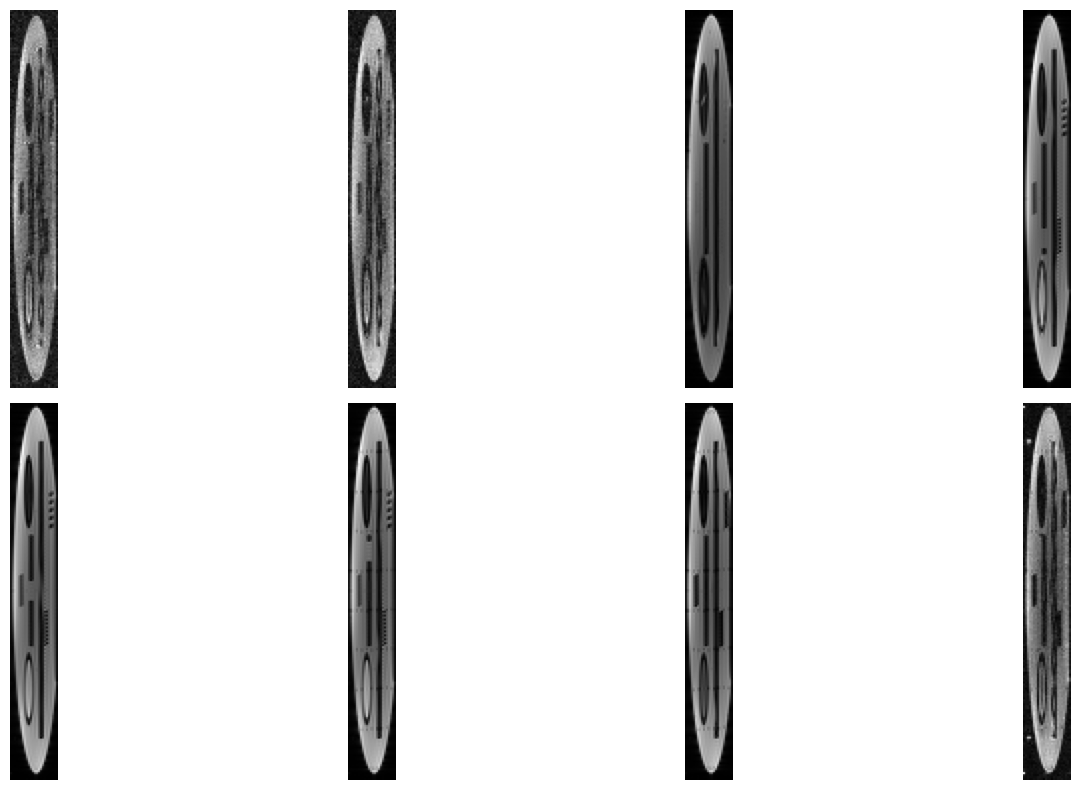

In [6]:
# sum of square of reference scan
acs_img = mrd.kspace_to_image(mrd.kspace['acs'])
acs_img = mrd.remove_oversampling(acs_img)
acs_img = mrd.coil_combination(acs_img, method='sos')

temp = acs_img.squeeze()[:,:,::3]
print(temp.shape)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[...,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 


In [7]:
%%time
# calculate coil sensitivity, using espirit method
coils_sensitivity = mrd.calc_coil_sensitivity(mrd.kspace['acs'], method='espirit')
print(coils_sensitivity.shape)

# display coil sensitivity
temp = coils_sensitivity[::2,...,14,0].squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 4))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[index+i*4,...].T),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 

In [ ]:
%%time
# remove oversampling and calculate coil sensitivity, using espirit method
# acs_img = mrd.kspace_to_image(mrd.kspace['acs'])
# acs_img = mrd.remove_oversampling(acs_img)
# acs_img = mrd.image_to_kspace(acs_img)
# coils_sensitivity_os_removed = mrd.calc_coil_sensitivity(acs_img, method='espirit')
# print(coils_sensitivity_os_removed.shape)

In [ ]:
%%time
# calculate coil sensitivity, using caldir method
coils_sensitivity_caldir = mrd.calc_coil_sensitivity(mrd.kspace['acs'], method='caldir')

# display coil sensitivity
temp = coils_sensitivity_caldir[::2,...,14,0].squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 4))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[index+i*4,...].T),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 


In [ ]:
%%time
#calculate coil sensitivity, using walsh method
acs = mrd.kspace_to_image(mrd.kspace['acs'])
coils_sensitivity_walsh = mrd.calc_coil_sensitivity(acs, method='walsh')

# display coil sensitivity
temp = coils_sensitivity_walsh[::2,...,14,0].squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 4))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[index+i*4,...].T),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 

In [ ]:
# reconstruct image with a simple coil combination
volume_comb = mrd.coil_combination(mrd.img, method='adaptive', coil_sens=coils_sensitivity)
volume_comb = mrd.remove_oversampling(volume_comb)
print(volume_comb.shape)

temp = volume_comb.squeeze()[...,::3]
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[:,:,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 

In [ ]:
%%time
# reconstruct image with bart
volume_comb = mrd.coil_combination(mrd.kspace['image_scan'], method='bart', coil_sens=coils_sensitivity)
print(volume_comb.shape)

In [ ]:
# display reconstructed image with bart
volume_comb = mrd.remove_oversampling(volume_comb)
temp = volume_comb.squeeze()[...,::3]
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[:,:,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 